<a href="https://colab.research.google.com/github/DilshadFayiz/AI-project-Biotecnika/blob/main/QSAR_modelling(IKKB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Load the CSV files of IKKβ inhibitors and gneratered molecules into pandas DataFrames, explicitly specifying the 'latin1' encoding to resolve the `UnicodeDecodeError`, and then display the head and columns of both DataFrames.

In [ ]:
import pandas as pd

df_inhibitors = pd.read_csv('/content/IKKβ _inhibitors.csv', encoding='latin1')
df_generated_molecules = pd.read_csv('/content/Generated_molecules.csv', encoding='latin1')

print("df_inhibitors head:")
print(df_inhibitors.head())
print("\ndf_inhibitors columns:")
print(df_inhibitors.columns)

print("\ndf_generated_molecules head:")
print(df_generated_molecules.head())
print("\ndf_generated_molecules columns:")
print(df_generated_molecules.columns)

df_inhibitors head:
  Compound_Name  MOL_WEIGHT  IC50 (µM)  \
0  CHEMBL360691     394.519    0.02500   
1  BDBM50149830     408.546    0.05000   
2  CHEMBL426532     454.552    0.25119   
3     BDBM25950     337.408    0.36000   
4  BDBM50325370     406.534    0.07900   

                                         Target Name  \
0  Inhibitor of nuclear factor kappa-B kinase sub...   
1  Inhibitor of nuclear factor kappa-B kinase sub...   
2  Inhibitor of nuclear factor kappa-B kinase sub...   
3  Inhibitor of nuclear factor kappa-B kinase sub...   
4  Inhibitor of nuclear factor kappa-B kinase sub...   

                                              SMILES  
0      CCCCCCOc1cccc(O)c1-c1cc(C2CCNCC2)c(C#N)c(N)n1  
1     CCCCCCCOc1cccc(O)c1-c1cc(C2CCNCC2)c(C#N)c(N)n1  
2  COCCCNNS(=O)(=O)c1ccc(-c2cc(-c3ccccc3)cc(C(N)=...  
3           Cc1cnc2c(NCC(N)=O)nc3cc(-c4ccccc4)sc3n12  
4   CCN(CC)CCNC(=O)c1ccc(-c2cnc3ccc(NCC4CC4)nn23)cc1  

df_inhibitors columns:
Index(['Compound_Name', 'MOL_WEIGHT'

##Generate Molecular Descriptors

In [ ]:
!pip install rdkit

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd

def smiles_to_mol(smiles):
    """Converts a SMILES string to an RDKit molecule object. Handles invalid SMILES."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            Chem.SanitizeMol(mol)
        return mol
    except:
        return None

print("RDKit modules imported and smiles_to_mol function defined.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 55.1 MB/s eta 0:00:00
RDKit modules imported and smiles_to_mol function defined.


# Task
Apply the `smiles_to_mol` function to the 'SMILES' column of both `df_inhibitors` and `df_generated_molecules` DataFrames to create new columns named 'Mol' containing RDKit molecule objects. Then, filter out any rows where the 'Mol' object is `None` (indicating invalid SMILES) from both DataFrames, and print the shape of the DataFrames after cleaning to show the number of valid molecules remaining.

### Subtask:
Convert SMILES strings to RDKit molecule objects and filter out invalid entries.


In [ ]:
df_inhibitors['Mol'] = df_inhibitors['SMILES'].apply(smiles_to_mol)
df_generated_molecules['Mol'] = df_generated_molecules['SMILES'].apply(smiles_to_mol)

df_inhibitors_cleaned = df_inhibitors.dropna(subset=['Mol'])
df_generated_molecules_cleaned = df_generated_molecules.dropna(subset=['Mol'])

print(f"Shape of df_inhibitors after cleaning: {df_inhibitors_cleaned.shape}")
print(f"Shape of df_generated_molecules after cleaning: {df_generated_molecules_cleaned.shape}")

Shape of df_inhibitors after cleaning: (564, 6)
Shape of df_generated_molecules after cleaning: (55, 3)


[08:01:44] SMILES Parse Error: syntax error while parsing: Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(NC(=O)c4ccccc4Cl)ccc2CC3)cc1
[08:01:44] SMILES Parse Error: check for mistakes around position 10:
[08:01:44] Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(N
[08:01:44] ~~~~~~~~~^
[08:01:44] SMILES Parse Error: extra open parentheses while parsing: Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(NC(=O)c4ccccc4Cl)ccc2CC3)cc1
[08:01:44] SMILES Parse Error: check for mistakes around position 7:
[08:01:44] Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(N
[08:01:44] ~~~~~~^
[08:01:44] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(NC(=O)c4ccccc4Cl)ccc2CC3)cc1' for input: 'Cc1ccc(-n+B401:B4422nc(C(N)=O)c3c2-c2cc(NC(=O)c4ccccc4Cl)ccc2CC3)cc1'


## Prepare Data for Modeling

### Subtask:
Align the generated molecular descriptors to ensure consistency between the training and prediction datasets. Handle any missing values or inconsistencies. Split the training data into training and validation sets to evaluate the model performance.


In [ ]:
common_cols = list(set(inhibitors_descriptors.columns) & set(generated_molecules_descriptors.columns))

# Filter both dataframes to retain only common columns
inhibitors_descriptors_aligned = inhibitors_descriptors[common_cols]
generated_molecules_descriptors_aligned = generated_molecules_descriptors[common_cols]

print(f"Number of common columns: {len(common_cols)}")
print("Inhibitors Descriptors Aligned Shape: ", inhibitors_descriptors_aligned.shape)
print("Generated Molecules Descriptors Aligned Shape: ", generated_molecules_descriptors_aligned.shape)

Number of common columns: 217
Inhibitors Descriptors Aligned Shape:  (564, 217)
Generated Molecules Descriptors Aligned Shape:  (55, 217)


In [ ]:
def calculate_rdkit_descriptors(mol):
    """Calculates RDKit descriptors for a given molecule."""
    if mol is None:
        return None
    return Descriptors.CalcMolDescriptors(mol)

# Generate descriptors for inhibitors
print("Generating descriptors for inhibitors...")
inhibitors_descriptors_list = df_inhibitors_cleaned['Mol'].apply(calculate_rdkit_descriptors)
inhibitors_descriptors = pd.DataFrame(inhibitors_descriptors_list.tolist())

# Generate descriptors for generated molecules
print("Generating descriptors for generated molecules...")
generated_molecules_descriptors_list = df_generated_molecules_cleaned['Mol'].apply(calculate_rdkit_descriptors)
generated_molecules_descriptors = pd.DataFrame(generated_molecules_descriptors_list.tolist())

print("\nInhibitors Descriptors Head:")
print(inhibitors_descriptors.head())
print(f"Inhibitors Descriptors Shape: {inhibitors_descriptors.shape}")

print("\nGenerated Molecules Descriptors Head:")
print(generated_molecules_descriptors.head())
print(f"Generated Molecules Descriptors Shape: {generated_molecules_descriptors.shape}")

Generating descriptors for inhibitors...
Generating descriptors for generated molecules...

Inhibitors Descriptors Head:
   MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0          10.568343       10.568343           0.100858        0.100858   
1          10.600253       10.600253           0.103103        0.103103   
2          12.471424       12.471424           0.091113       -3.736579   
3          11.073420       11.073420           0.023565       -0.436465   
4          12.421849       12.421849           0.044874       -0.044874   

        qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.575625  14.482759  394.519         364.279  394.236876   
1  0.518499  14.400000  408.546         376.290  408.252526   
2  0.211074  11.406250  454.552         428.344  454.167476   
3  0.599500  11.208333  337.408         322.288  337.099731   
4  0.540440  13.700000  406.534         376.294  406.248110   

   NumValenceElectrons  ...  fr_sulfide  fr_sulfo

## Train QSAR Model

### Subtask:
Train a QSAR model (e.g., Random Forest Regressor) using the molecular descriptors and activity values, and evaluate its performance on the validation set.


In [ ]:
from sklearn.model_selection import train_test_split

# Create the full training dataset
# Ensure indices are aligned before concatenating
df_inhibitors_cleaned_reset = df_inhibitors_cleaned.reset_index(drop=True)
inhibitors_descriptors_aligned_reset = inhibitors_descriptors_aligned.reset_index(drop=True)

training_data = pd.concat([
inhibitors_descriptors_aligned_reset,
    df_inhibitors_cleaned_reset['IC50 (µM)']
], axis=1)

print("Shape of training_data before handling NaNs:", training_data.shape)

# Check for and handle any missing values (NaNs)
missing_values_count = training_data.isnull().sum().sum()
if missing_values_count > 0:
    print(f"Found {missing_values_count} missing values in the training data. Dropping rows with NaNs.")
    training_data.dropna(inplace=True)
    print("Shape of training_data after dropping NaNs:", training_data.shape)
else:
    print("No missing values found in the training data.")

# Separate the features (X) and the target variable (y)
X = training_data.drop('IC50 (µM)', axis=1)
y = training_data['IC50 (µM)']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Split the features (X) and target (y) into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

Shape of training_data before handling NaNs: (564, 218)
Found 32 missing values in the training data. Dropping rows with NaNs.
Shape of training_data after dropping NaNs: (560, 218)
Shape of X: (560, 217)
Shape of y: (560,)
X_train shape: (448, 217)
X_val shape: (112, 217)
y_train shape: (448,)
y_val shape: (112,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Instantiate a RandomForestRegressor model
# Using random_state for reproducibility
model = RandomForestRegressor(random_state=42)

# Train the model
print("Training Random Forest Regressor model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate and print the R-squared score
r2 = r2_score(y_val, y_pred)
print(f"R-squared score on the validation set: {r2:.4f}")

# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE) on the validation set: {rmse:.4f}")

Training Random Forest Regressor model...
Model training complete.
R-squared score on the validation set: 0.8256
Root Mean Squared Error (RMSE) on the validation set: 0.1672


## Predict Activity for Generated Molecules

### Subtask:
Use the trained QSAR model to predict the activity of the AI-generated molecules from the 'Generated_molecules.csv' file based on their calculated molecular descriptors.


In [ ]:
import numpy as np

# Replace infinite values with NaN
generated_molecules_descriptors_aligned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values from the generated molecules descriptors
initial_shape = generated_molecules_descriptors_aligned.shape
generated_molecules_descriptors_aligned.dropna(inplace=True)

if generated_molecules_descriptors_aligned.shape[0] < initial_shape[0]:
    print(f"Dropped {initial_shape[0] - generated_molecules_descriptors_aligned.shape[0]} rows from generated_molecules_descriptors_aligned due to NaN or infinite values.")

# Also, ensure df_generated_molecules_cleaned is aligned with the dropped rows
df_generated_molecules_cleaned = df_generated_molecules_cleaned.loc[generated_molecules_descriptors_aligned.index]

predicted_activities = model.predict(generated_molecules_descriptors_aligned)
df_generated_molecules_cleaned['Predicted IC50 (µM)'] = predicted_activities

print("df_generated_molecules_cleaned head with predicted activities:")
print(df_generated_molecules_cleaned.head())

Dropped 4 rows from generated_molecules_descriptors_aligned due to NaN or infinite values.
df_generated_molecules_cleaned head with predicted activities:
  MOLECULE_ID                                             SMILES  \
0       Mol.1  NNCOC=C=NCNN=C=NC=CN=CN=C(C=NC)OC[CH]C1C(CC#C)...   
1       Mol.2  [O-]C[CH]CCCNNC=C(C(C=C(NSC=CC(C=NC(CC=C1CC2=N...   
2       Mol.3  N=COC(NC=CCNC(C=C(S[S]=CC#CCP)CC=CC=CC=C=N)C=C...   
3       Mol.4                                 [C-]1=[S]NOCC1N=NF   
4       Mol.5                                  [CH][C-]OC=[S]ONN   

                                                Mol  Predicted IC50 (µM)  
0  <rdkit.Chem.rdchem.Mol object at 0x7f736501f8b0>             0.477924  
1  <rdkit.Chem.rdchem.Mol object at 0x7f736501f920>             0.299843  
2  <rdkit.Chem.rdchem.Mol object at 0x7f736501f990>             0.334482  
3  <rdkit.Chem.rdchem.Mol object at 0x7f736501fa00>             0.416121  
4  <rdkit.Chem.rdchem.Mol object at 0x7f736501fa70>           

## Analyze and Visualize Predicted Activities

### Subtask:
Analyze the distribution of predicted activities for the AI-generated molecules. Generate a histogram or a distribution plot to visualize the range and frequency of the predicted activities. Compare these predictions to the known activities from the training set, if relevant, to understand the potential of the generated molecules. Ensure all plots include appropriate labels and legends.


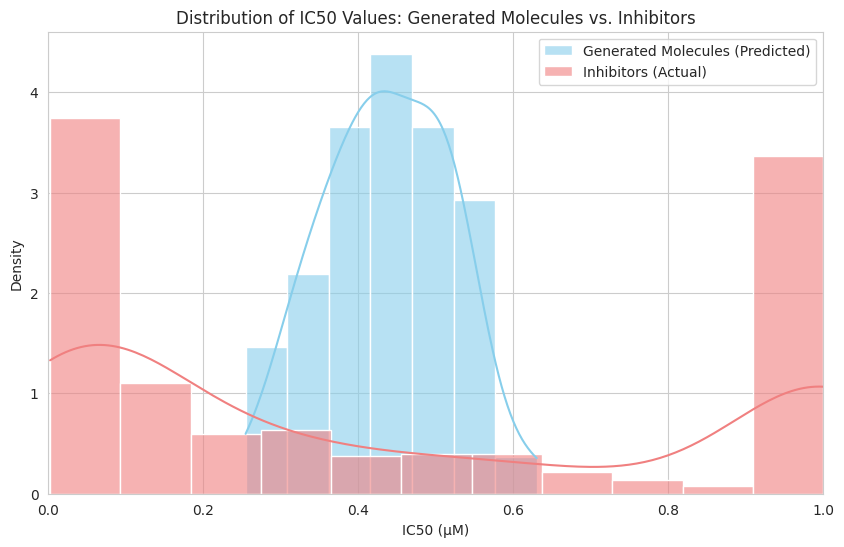

Generated molecule predictions compared to inhibitor actual activities plot displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Plot the distribution of predicted IC50 for generated molecules
sns.histplot(df_generated_molecules_cleaned['Predicted IC50 (µM)'], color='skyblue', label='Generated Molecules (Predicted)', kde=True, stat='density', alpha=0.6)

# Plot the distribution of actual IC50 for inhibitors (training data)
sns.histplot(y, color='lightcoral', label='Inhibitors (Actual)', kde=True, stat='density', alpha=0.6)

plt.title('Distribution of IC50 Values: Generated Molecules vs. Inhibitors')
plt.xlabel('IC50 (µM)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1) # Limit x-axis to a reasonable range for IC50 values
plt.show()

print("Generated molecule predictions compared to inhibitor actual activities plot displayed.")

## Download the results

In [ ]:
output_df_sorted = df_generated_molecules_cleaned.sort_values(by='Predicted IC50 (µM)', descending=False)
print("Predicted IC50 values sorted in ascending order:")
print(output_df_sorted.head())

Predicted IC50 values sorted in descending order:
   MOLECULE_ID                    SMILES  \
44      Mol.45  C#CC1(CSC=CN2O[CH]2)C=C1   
22      Mol.23              C[CH]NC#CN=O   
35      Mol.36            [O-][CH][CH]Br   
21      Mol.22         O=C=CCC=C=NC=NC=O   
32      Mol.33         [C]([S]=O)P[N+]#C   

                                                 Mol  Predicted IC50 (µM)  
44  <rdkit.Chem.rdchem.Mol object at 0x7f7365024c80>             0.630389  
22  <rdkit.Chem.rdchem.Mol object at 0x7f73650242e0>             0.573923  
35  <rdkit.Chem.rdchem.Mol object at 0x7f7365024890>             0.558889  
21  <rdkit.Chem.rdchem.Mol object at 0x7f7365024270>             0.536701  
32  <rdkit.Chem.rdchem.Mol object at 0x7f7365024740>             0.536480  


In [ ]:
output_filename = 'generated_molecules_predicted_ic50_sorted.csv'
output_df_sorted.to_csv(output_filename, index=False)
print(f"Sorted predicted IC50 values saved to {output_filename}")

Sorted predicted IC50 values saved to generated_molecules_predicted_ic50_sorted.csv
